In [2]:
cd ..

/home/osselinp/semisupervised


In [3]:
import numpy as np
from typing import Callable, Optional, Tuple
from module.quadrature import Quadrature, QuadratureExploration, QuadratureExplorationBis
from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import scipy.stats as stats
from botorch.optim import optimize_acqf


def plot_GP_fit(model, distribution, train_X, targets, obj, normalize=False, lb=-10., up=10., mean_Y=None, std_Y=None):
    """ Plot the figures corresponding to the Gaussian process fit
    """
    model.eval()
    model.likelihood.eval()
    test_x = torch.linspace(lb, up, 200, device=train_X.device, dtype=train_X.dtype)
    with torch.no_grad():
        # Make predictions
        predictions = model.likelihood(model(test_x))
        lower, upper = predictions.confidence_region()
    
    if normalize:
        predictions = predictions*float(std_Y) + float(mean_Y)
        lower, upper = lower*float(std_Y) + float(mean_Y), upper*float(std_Y) + float(mean_Y)
        targets = targets*float(std_Y) + float(mean_Y)
    value_ = (obj(test_x.unsqueeze(-1))).flatten()

    plt.scatter(train_X.cpu().numpy(), targets.cpu().numpy(), color='black', label='Training data')
    plt.plot(test_x.cpu().numpy(), predictions.mean.cpu().numpy(), color='blue', label='Predictive mean')
    plt.plot(test_x.cpu().numpy(), value_.cpu().numpy(), color='green', label='True Function')
    plt.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color='lightblue', alpha=0.5, label='Confidence region')
    
    x = np.linspace(distribution.loc - 3*distribution.covariance_matrix, distribution.loc + 3*distribution.covariance_matrix, 100).flatten()
    y_lim = plt.gca().get_ylim()
    plt.plot(x, (y_lim[1] - y_lim[0])*stats.norm.pdf(x, distribution.loc, distribution.covariance_matrix).flatten(), "k")
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    bounds=torch.tensor([[-5.], [5.]])

    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=5,
        num_restarts=10,
        raw_samples=512,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x = candidates
    return new_x

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


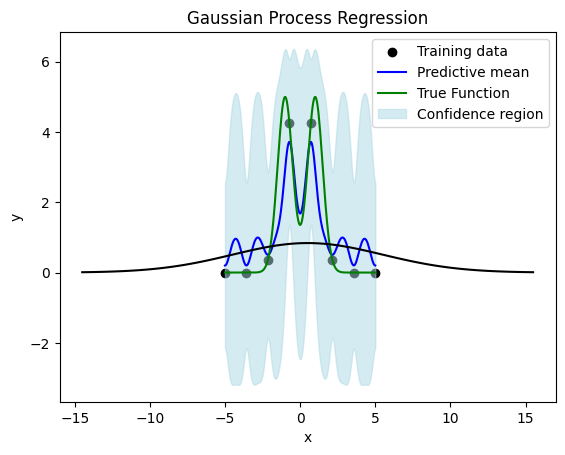

In [4]:
objective = lambda x: -x**2
#objective = lambda x: -20.0 * torch.exp(-0.2 * torch.sqrt(0.5 * x**2))-torch.exp(0.5 * (torch.cos(2*torch.pi*x))) + torch.exp(torch.tensor(1.)) + 20
objective = lambda x: 5*torch.exp(-2*(x - 1)**2) + 5*torch.exp(-2*(x + 1)**2)

from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

mean_distrib, var_distrib = torch.tensor([0.5]), torch.diag(torch.tensor([5.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 8
bounds = 5
lb, up= -5., 5.
train_X = torch.linspace(-bounds,bounds, n, dtype=torch.float64).reshape(-1,1)
#train_Y = (objective(train_X)).sum(dim=1, keepdim=True)
train_Y = objective(train_X).reshape(-1,1)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y = None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


plot_GP_fit(model, quad_distrib, train_X, train_Y, objective, normalize=NORMALIZE, lb=lb, up=up, mean_Y=mean_Y, std_Y=std_Y)

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


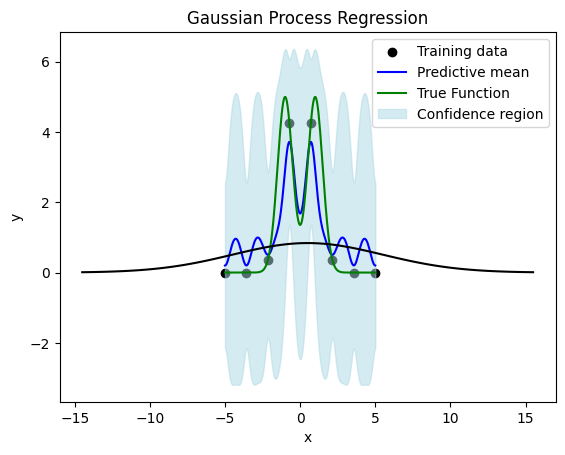

result_optimi tensor([[-3.5943],
        [ 3.4663],
        [ 0.4721],
        [ 0.4723],
        [ 0.4723]])
result_sampling tensor([[0.4999],
        [0.4999],
        [0.4999],
        [0.4999],
        [0.5000]])
Maximizing: tensor([0.9309], dtype=torch.float64, grad_fn=<SumBackward1>) vs sampling: tensor([0.9373], dtype=torch.float64, grad_fn=<SumBackward1>)


In [7]:
objective = lambda x: -x**2
#objective = lambda x: -20.0 * torch.exp(-0.2 * torch.sqrt(0.5 * x**2))-torch.exp(0.5 * (torch.cos(2*torch.pi*x))) + torch.exp(torch.tensor(1.)) + 20
objective = lambda x: 5*torch.exp(-2*(x - 1)**2) + 5*torch.exp(-2*(x + 1)**2)

from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

mean_distrib, var_distrib = torch.tensor([0.5]), torch.diag(torch.tensor([5.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 8
bounds = 5
lb, up= -5., 5.
train_X = torch.linspace(-bounds,bounds, n, dtype=torch.float64).reshape(-1,1)
#train_Y = (objective(train_X)).sum(dim=1, keepdim=True)
train_Y = objective(train_X).reshape(-1,1)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y = None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


plot_GP_fit(model, quad_distrib, train_X, train_Y, objective, normalize=NORMALIZE, lb=lb, up=up, mean_Y=mean_Y, std_Y=std_Y)


mean_distrib, var_distrib = torch.tensor([0.5]), torch.diag(torch.tensor([.000000001]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
acq_ = QuadratureExplorationBis(model=model,
                                distribution= quad_distrib)
sample = quad_distrib.rsample(torch.tensor([5000, 5]))
res = acq_(sample)

result_optimi = optimize_acqf_and_get_observation(acq_)
result_sampling = sample[torch.argmax(res)]
print("result_optimi", result_optimi)
print("result_sampling", result_sampling)

print(f"Maximizing: {acq_(optimize_acqf_and_get_observation(acq_))} vs sampling: {acq_(result_sampling)}")


In [23]:
optimize_acqf_and_get_observation(acq_).size()

torch.Size([5, 1])

In [14]:
quad_distrib.rsample(100)

TypeError: 'int' object is not iterable

tensor(0.1870, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [31]:
sample[torch.argmax(res)]

tensor([[ 0.2495],
        [ 2.1900],
        [-0.8335],
        [ 1.5858],
        [ 0.9075]])